### Project 2 Problem 2

# Onkar Kher

# UID: 120407062
# Directory ID: okher


Image Processing pipeline (A)

Loading the images, stored in Google Drive

Loading image from the path: /content/drive/MyDrive/ENPM673/Project2/Images/1.JPG
Loading image from the path: /content/drive/MyDrive/ENPM673/Project2/Images/2.JPG
Loading image from the path: /content/drive/MyDrive/ENPM673/Project2/Images/3.JPG
Loading image from the path: /content/drive/MyDrive/ENPM673/Project2/Images/4.JPG


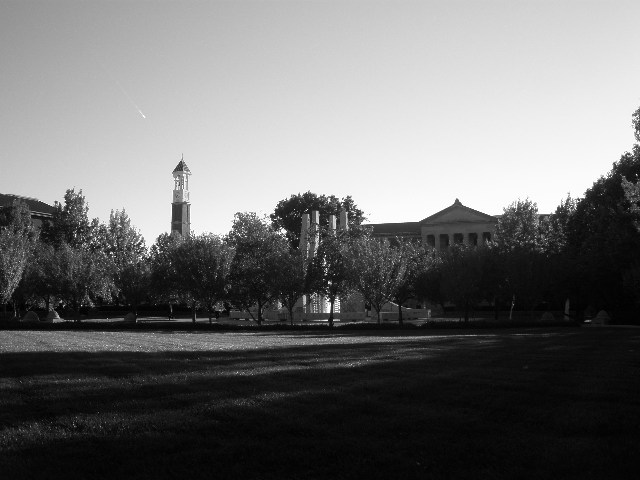

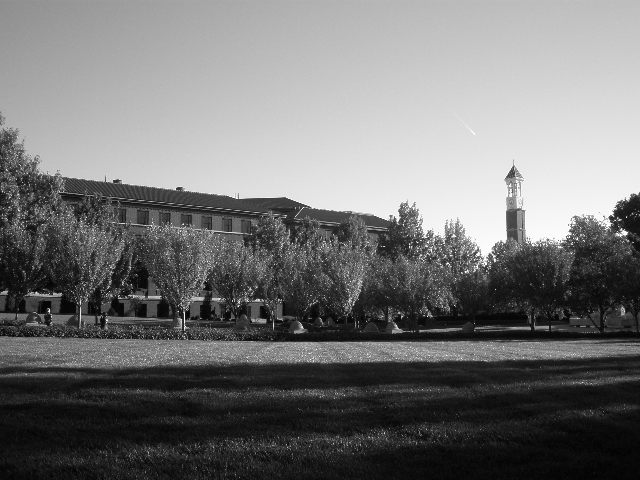

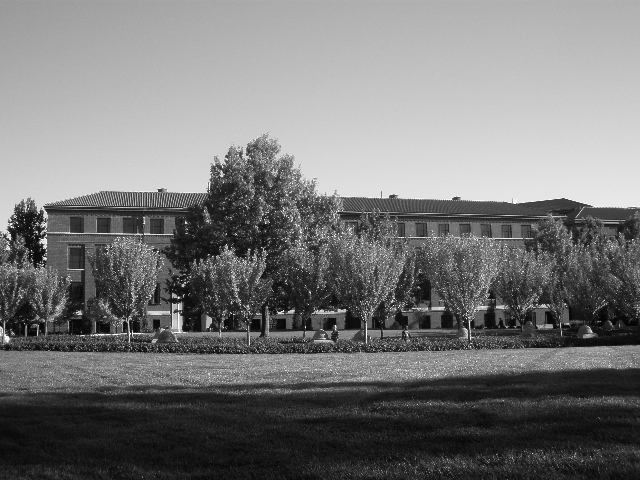

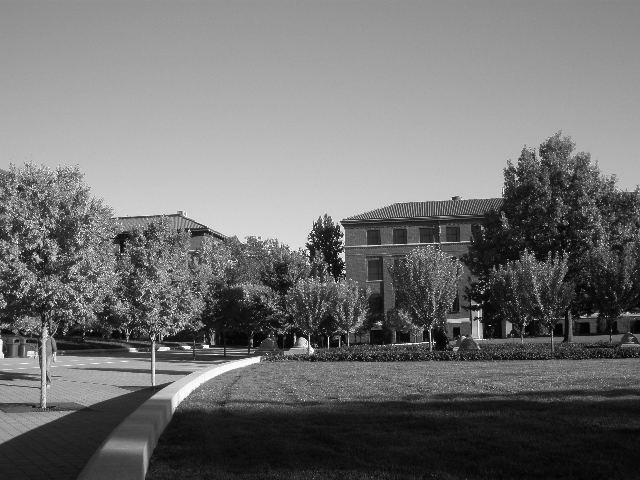

In [ ]:
import cv2
import sys
from google.colab.patches import cv2_imshow
from google.colab import drive
import numpy as np

input_images = []

for i in range(1, 5):
    # Images have been renamed as 1.JPG, 2.JPG, 3.JPg and 4.JPG, on the given path.
    path = f"/content/drive/MyDrive/ENPM673/Project2/Images/{i}.JPG"  # Make sure the path is correct
    print("Loading image from the path:", path)
    image = cv2.imread(path, 0)
    if image is not None:
        input_images.append(image)
    else:
        print(f"Failed to load image from {path}")

for img in input_images:
    cv2_imshow(img)


Step 1: Extract features from each frame (You can use any feature extractor and justify).

In [ ]:
#Using ORB for feature extraction as it is comparable to SIFT in terms of results and open-source unlike SIFT.

orb = cv2.ORB_create()
keypoints_list = []
descriptors_list = []

for img in input_images:
  # Finding the keypoints and descriptors with the help of the ORB feature extractor
  keypoints, descriptors = orb.detectAndCompute(img, None)
  keypoints_list.append(keypoints)
  descriptors_list.append(descriptors)

Step 2 and 3: Match the features between each consecutive image and visualize them. (hint: Use RANSAC), and compute the homographies between the pairs of images.

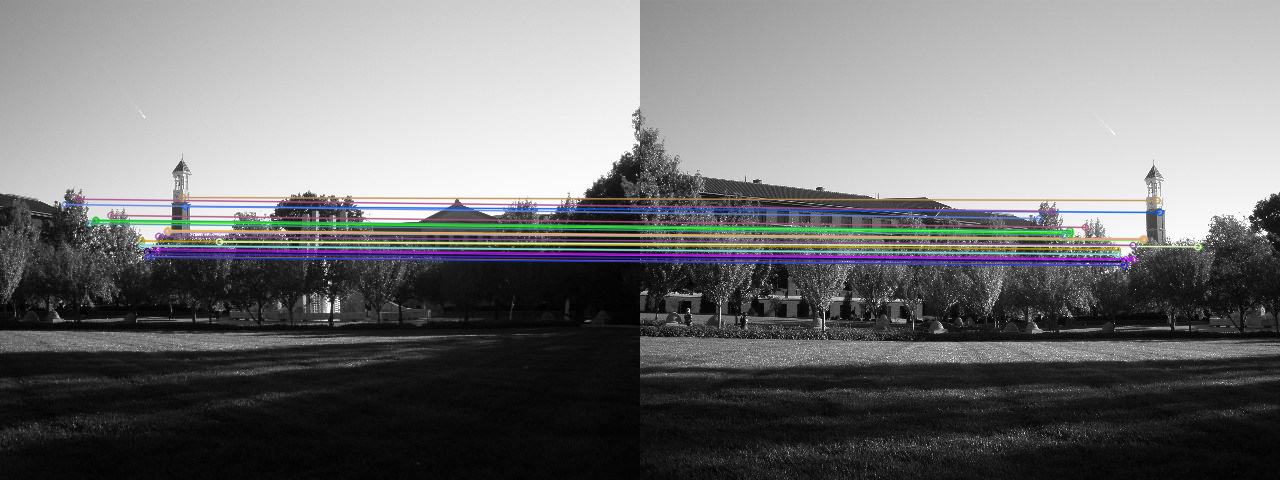

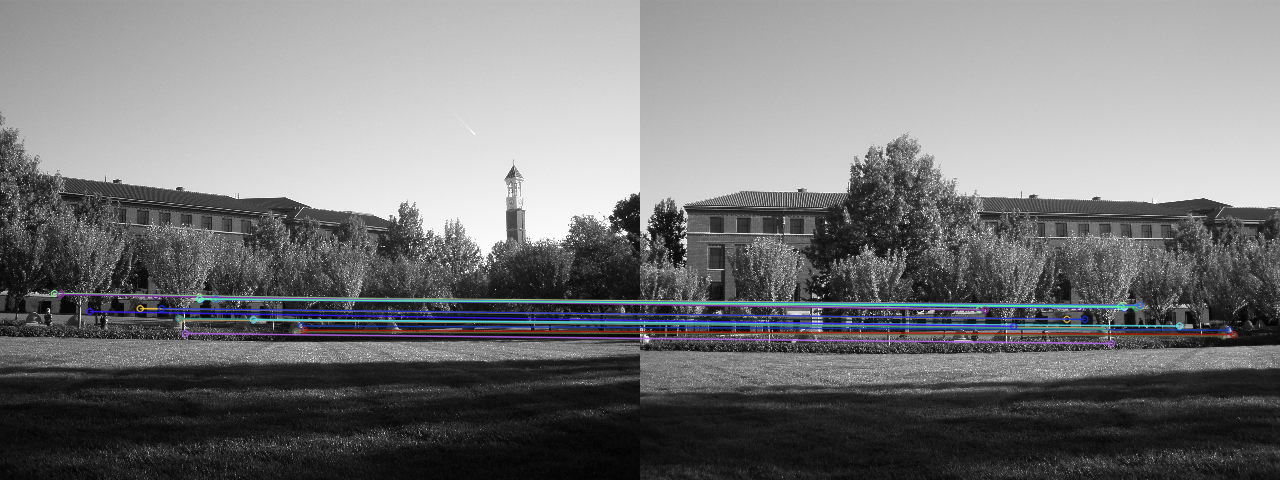

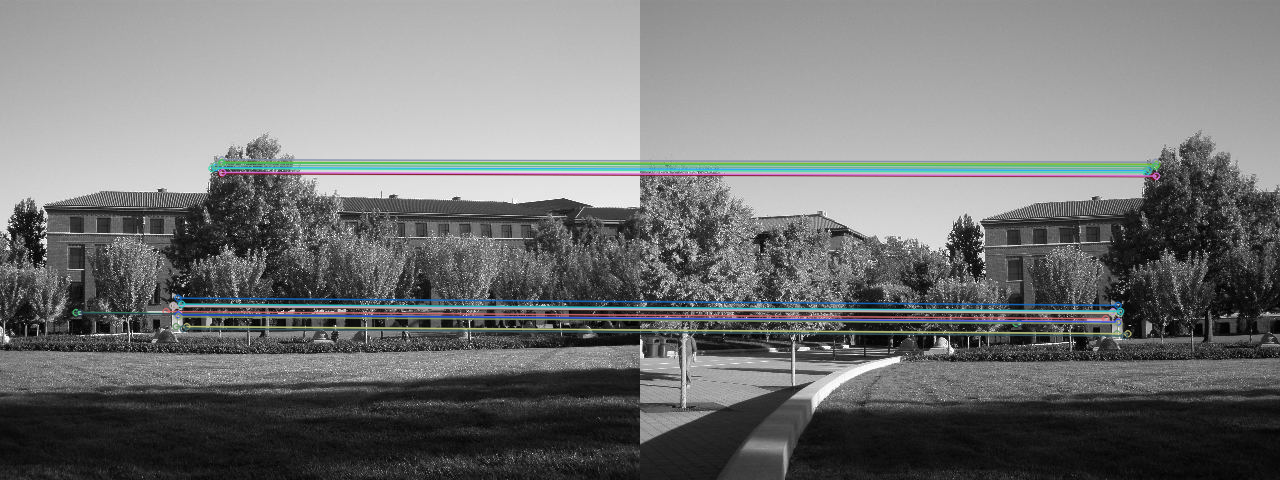

In [ ]:
#List to store homographies detected
store_homographies = []

for i in range(len(input_images) - 1):
  # Creating a Brute Force matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  # Matching the stored in the descriptors list
  matches = bf.match(descriptors_list[i], descriptors_list[i+1])
  # Sorting them in the order of their distances
  matches = sorted(matches, key = lambda x:x.distance)

  # Limiting the matched points to the first 25 so as to reduce the cluster, and to prevent noise being mapped too.
  img_matches = cv2.drawMatches(input_images[i], keypoints_list[i], input_images[i+1], keypoints_list[i+1], matches[:25], None, flags=2)
  cv2_imshow(img_matches)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

  # Extracting the location of the good matches
  points_1 = np.zeros((len(matches), 2), dtype=np.float32)
  points_2 = np.zeros((len(matches), 2), dtype=np.float32)

  for j, match in enumerate(matches):
      points_1[j, :] = keypoints_list[i][match.queryIdx].pt
      points_2[j, :] = keypoints_list[i+1][match.trainIdx].pt

  # Computing the obtained homography
  H, masking_var = cv2.findHomography(points_1, points_2, cv2.RANSAC, 5.0)

  store_homographies.append(H)

Step 4: Combine these frames together using the computed homographies.

In [ ]:
# Using the first image as the reference frame
panoramic_image = input_images[0]
for i in range(1, len(input_images)):
    # Warping the current image onto the result image
    panoramic_image = cv2.warpPerspective(panoramic_image, store_homographies[i-1], (panoramic_image.shape[1] + input_images[i].shape[1], panoramic_image.shape[0]))
    panoramic_image[0:input_images[i].shape[0], 0:input_images[i].shape[1]] = input_images[i]

Displaying the panoramic image so produced.


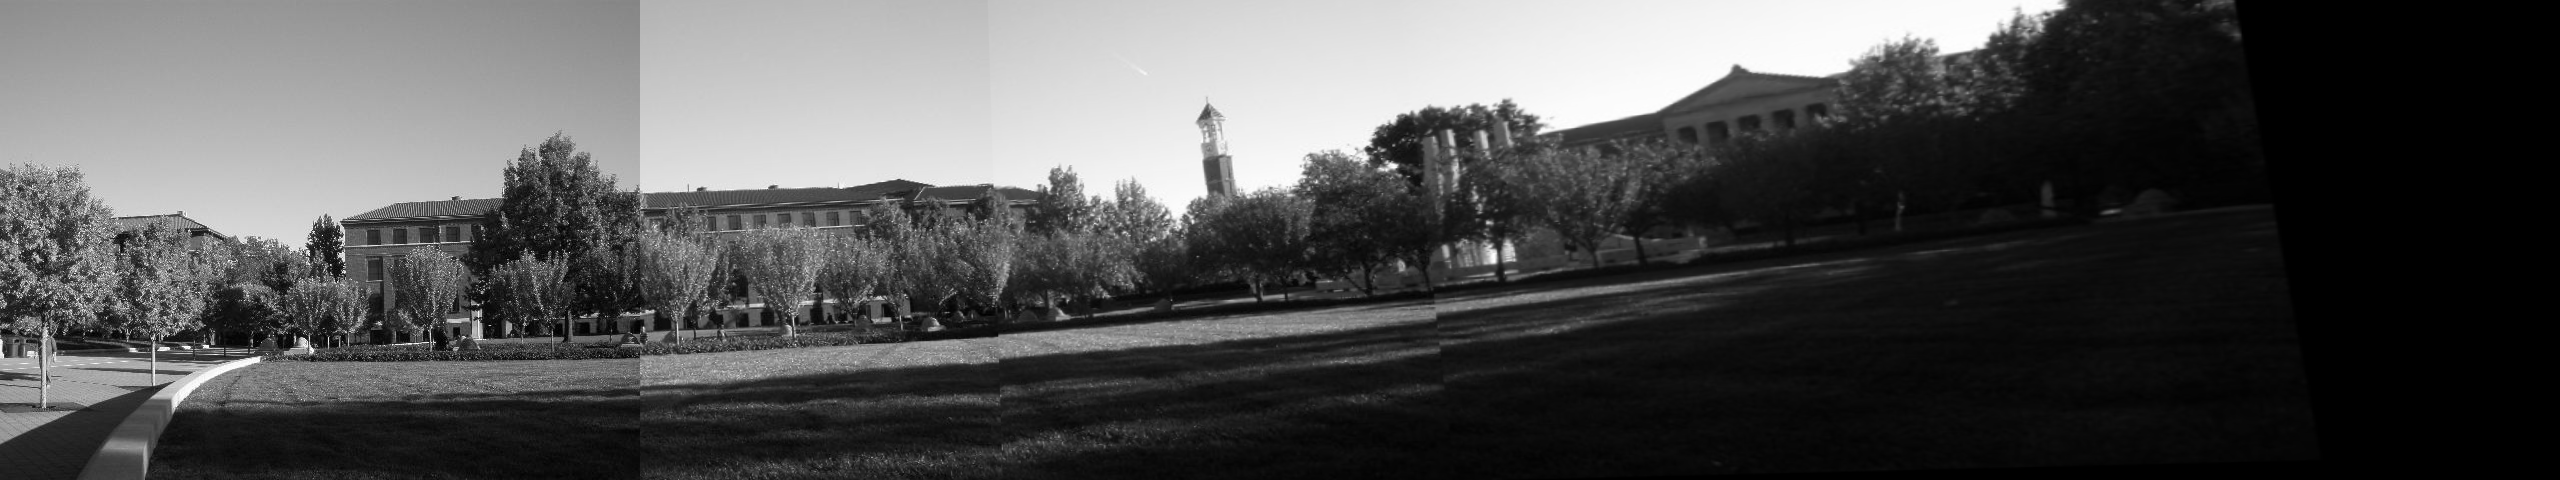

In [ ]:
cv2_imshow(panoramic_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


B) In general, why does panoramic mosaicing work better when the camera is only allowed to rotate at its camera center?

Answer: Panoramic mosaicing works better when the camera is only allowed to rotate about its center (often referred to as the nodal point) due to several reasons related to perspective, parallax, and the mathematical models used for image stitching. Here are the key reasons:

1. Minimized Parallax Error: Parallax is the apparent shift in position of an object when viewed from different angles. This is particularly noticeable when objects are at varying distances from the camera. If the camera rotates around its center, objects in the scene maintain their relative positions more consistently across images, significantly reducing parallax errors. This makes feature matching and alignment easier and more accurate, leading to better stitching results.

2. Simplification of Homography Calculation: The process of stitching images together often involves calculating a homography matrix, which describes the transformation between two views of a plane. When the camera rotates around its center without any translational movement, this transformation can be accurately modeled as a rotation (and potentially some scale and skew), simplifying the homography calculation. This is because the relationship between the views is more straightforward, and the mathematical model (pure rotation) fits the physical movement of the camera more accurately.

3. Consistent Scale and Depth: When the camera rotates around its center, the scale and depth of the scene remain consistent across different images. This consistency helps in maintaining uniformity in the appearance of objects, making it easier to merge images without noticeable artifacts or discrepancies in object sizes.

4. Elimination of Need for Complex Depth Estimation: In general panoramic mosaicing, especially when dealing with scenes that are not planar, accurately modeling the scene depth and camera motion (including translation) can be complex and computationally expensive. By restricting the camera to rotate around its center, the need for complex depth estimation is eliminated.
It's much easier to achieve overlap when the camera rotates around its center. This helps to keep a consistent field of view in each image, which is important for detecting common features during the alignment and stitching process.

In summary, restricting the camera to rotate around its center simplifies the mathematical models for image transformation, reduces parallax errors, maintains consistent scale and depth across images, and minimizes the computational complexity of stitching, resulting in more accurate and visually pleasing panoramic mosaics.